In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
from utils import extract_alloy, method_four, method_two, method_five, LSTM_Vectorizer, method_one
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Convolution2DTranspose, Concatenate, LSTM, Dropout, Reshape, Softmax, Dot, Conv1D, Input, Flatten, Embedding, Bidirectional

from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MaxAbsScaler, MinMaxScaler, StandardScaler,QuantileTransformer, PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold

from ml import run_all_regressors_with_transformers
import matplotlib.pyplot as plt
import math
from joblib import dump
import seaborn as sns
from scipy import stats
from hypopt import GridSearch

In [2]:
# Loading our compiled dataset of experimental D Max values and alloys
dataset = pd.read_csv("final_df.csv")
dataset.head()

,bmg_alloy,paper_sno,actual_d_max
0,Ti7.0Cu60.0Zr33.0,"[1, 5, 6, 7, 9]",3.00
1,Ti7.0Cu54.0Zr33.0Ag6.0,"[1, 5, 6, 7, 9]",6.00
2,Ti7.0Cu46.4Zr35.0Ag11.6,"[1, 5, 6, 7, 9]",6.00
3,Ti6.0Cu44.2Zr35.0Ag14.7,"[1, 6]",8.00
4,Ti5.0Cu44.2Zr36.0Ag14.7,"[1, 6]",10.00


In [3]:
# Transforming the alloys using weighted predefined embeddings
elements, composition = extract_alloy(np.copy(dataset["bmg_alloy"]))
init_features = method_four(elements, composition)

In [4]:
init_features.shape

(1587, 9, 200)

In [5]:
y = np.copy(dataset["actual_d_max"])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(init_features, y, test_size=0.2, random_state=42)

In [7]:
# Dimension reduction model
def make_bi_lstm_model():
    inp = Input(shape=(9,200))
    lstm = Bidirectional(LSTM(128, return_sequences=True, dropout=0.4))(inp)
    re_lstm = Reshape((1, lstm.shape[1], lstm.shape[2]))(lstm)
    conv = Dense(1, activation="sigmoid",)(re_lstm)
    re_conv = Reshape((lstm.shape[1],))(conv)
    prob = Softmax()(re_conv)
    weighted_lstm = Dot(axes=1)([prob, lstm])
    ff = Dense(128, activation="relu")(weighted_lstm)
    drop_ff = Dropout(0.4)(ff)
    out = Dense(1, activation="relu")(drop_ff)
    return tf.keras.Model(inputs=inp, outputs=out)

In [8]:
model = make_bi_lstm_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9, 200)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 9, 256)       336896      ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1, 9, 256)    0           ['bidirectional[0][0]']          
                                                                                                  
 dense (Dense)                  (None, 1, 9, 1)      257         ['reshape[0][0]']                
                                                                                              

In [9]:
# Compiling dimension reduction model
model.compile(optimizer="adam", loss="mean_squared_error")

In [10]:
# Training our dimension reduction model
history = model.fit(X_train, y_train, verbose=1, epochs=5000, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5000
20/20 [==============================] - 7s 51ms/step - loss: 30.5569 - val_loss: 20.9462
Epoch 2/5000
20/20 [==============================] - 0s 10ms/step - loss: 23.1627 - val_loss: 17.9510
Epoch 3/5000
20/20 [==============================] - 0s 11ms/step - loss: 19.9379 - val_loss: 15.7683
Epoch 4/5000
20/20 [==============================] - 0s 10ms/step - loss: 19.0817 - val_loss: 15.2319
Epoch 5/5000
20/20 [==============================] - 0s 11ms/step - loss: 17.9857 - val_loss: 14.2334
Epoch 6/5000
20/20 [==============================] - 0s 10ms/step - loss: 17.1159 - val_loss: 13.6121
Epoch 7/5000
20/20 [==============================] - 0s 10ms/step - loss: 16.8846 - val_loss: 13.1726
Epoch 8/5000
20/20 [==============================] - 0s 10ms/step - loss: 15.9869 - val_loss: 12.5671
Epoch 9/5000
20/20 [==============================] - 0s 11ms/step - loss: 16.2034 - val_loss: 12.3672
Epoch 10/5000
20/20 [==============================] - 0s 11ms/step - los

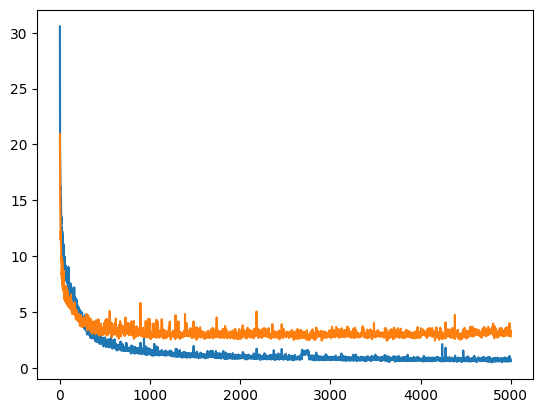

In [11]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [12]:
# Testing dimension reduction model
y_hat = model.predict(X_test)
r2_score(y_test, y_hat)

10/10 [==============================] - 1s 6ms/step


0.8712160436162726

In [21]:
# Saving dimension reduction model
model.save("attention_bi_lstm")

INFO:tensorflow:Assets written to: attention_bi_lstm\assets


INFO:tensorflow:Assets written to: attention_bi_lstm\assets


In [6]:
# Loading dimension reduction model
model = tf.keras.models.load_model("attention_bi_lstm")

In [7]:
# Extracting the intermediate layer of dimension reduction model
def get_inside(mod, layer):
    layer = mod.get_layer(layer)
    out = Flatten()(layer.output)
    return tf.keras.Model(inputs=mod.input, outputs=out)

In [8]:
feature_models = get_inside(model, "dot")

In [9]:
# Transforming the predefined embedding into lower dimensional vector representation 
attention_features = feature_models.predict(init_features)

50/50 [==============================] - 10s 10ms/step


In [10]:
attention_features.shape

(1587, 256)

In [27]:
# Storing validation results
validation_results = pd.DataFrame(columns=["Model", "MinMaxScalar", "StandardScalar", "MaxAbsScalar", "PowerTransformer", "QuantileTransformer", "Normalizer"])

In [28]:
# Testing different regressor algorithms on transformed input values using cross validation with 10 folds
def validate(name, temp, flag):
    results = [name]
    scalars = [MinMaxScaler, StandardScaler, MaxAbsScaler, PowerTransformer, QuantileTransformer, Normalizer]
    
    for i in scalars:
        scalar = i()
        X_temp_trans = scalar.fit_transform(attention_features)
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        y_pred_total = []
        y_test_total = []
        for train_index, test_index in kf.split(X_temp_trans):
            X_train, X_test = X_temp_trans[train_index], X_temp_trans[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            if flag == 1:
                cb = temp(n_jobs=-1)
            elif flag == 2:
                cb = temp(verbose=0)
            else:
                cb = temp()
            y_pred = cb.fit(X_train, y_train).predict(X_test)
        
            y_pred_total.append(y_pred)
            y_test_total.append(y_test)
        
        y_pred_total = np.array([item for sublist in y_pred_total for item in sublist])
        y_test_total = np.array([item for sublist in y_test_total for item in sublist])
        r2 = r2_score(y_test_total, y_pred_total)
        results.append(r2)
    
    
    validation_results.loc[len(validation_results.index)] = results

In [29]:
validate("Extra Tree", ExtraTreesRegressor, 1)
validate("Random Forest", RandomForestRegressor, 1)
validate("XGBoost", XGBRegressor, 2)
validate("LGBoost", LGBMRegressor, 2)
validate("CatBoost", CatBoostRegressor, 2)
validate("Gradient Boosting", GradientBoostingRegressor, 0)
validate("Ada Boost", AdaBoostRegressor, 0)

In [30]:
# Saving validation results
validation_results.to_csv("Validation_Results.csv")

In [11]:
# Transforming data with best performing scaler
scalar = MinMaxScaler()
X = scalar.fit_transform(attention_features)

In [38]:
# Saving the transformation scaler
dump(scalar, "MinMaxScalar.bin")

['MinMaxScalar.bin']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [17]:
# Optimizing the best performing regressor using grid search
cat_model = CatBoostRegressor(verbose=0)

grid = {'learning_rate': [0.01, 0.03, 0.1, 0.3, 0.9],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1.0, 3.0, 6.0, 9.0, 12.0, 20.0],
        'n_estimators': [100, 200, 250, 500, 1000]}

grid_search = cat_model.grid_search(grid, X=X_train, y=y_train, cv=10, plot=True)
print(f"R2 Score: {cat_model.score(X_test, y_test)}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 3.151634795
bestIteration = 99

0:	loss: 3.1516348	best: 3.1516348 (0)	total: 428ms	remaining: 4m 16s

bestTest = 1.485787766
bestIteration = 99

1:	loss: 1.4857878	best: 1.4857878 (1)	total: 960ms	remaining: 4m 47s

bestTest = 1.275644458
bestIteration = 98

2:	loss: 1.2756445	best: 1.2756445 (2)	total: 1.43s	remaining: 4m 45s

bestTest = 1.430060464
bestIteration = 88

3:	loss: 1.4300605	best: 1.2756445 (2)	total: 1.85s	remaining: 4m 36s

bestTest = 1.970457472
bestIteration = 43

4:	loss: 1.9704575	best: 1.2756445 (2)	total: 2.29s	remaining: 4m 32s

bestTest = 3.318533619
bestIteration = 99

5:	loss: 3.3185336	best: 1.2756445 (2)	total: 2.69s	remaining: 4m 26s

bestTest = 1.581461006
bestIteration = 99

6:	loss: 1.5814610	best: 1.2756445 (2)	total: 3.08s	remaining: 4m 20s

bestTest = 1.350799984
bestIteration = 99

7:	loss: 1.3508000	best: 1.2756445 (2)	total: 3.46s	remaining: 4m 15s

bestTest = 1.40098551
bestIteration = 96

8:	loss: 1.4009855	best: 1.2756445 (2)	total:

In [18]:
# Saving the regressor
cat_model.save_model("cat_boost_model")

In [12]:
# Loading regressor
cat_model = CatBoostRegressor().load_model("cat_boost_model")

In [8]:
# Optimized parameter of the regressor
cat_model.get_params()

{'depth': 4,
 'loss_function': 'RMSE',
 'learning_rate': 0.03,
 'l2_leaf_reg': 1,
 'iterations': 1000,
 'verbose': 0}

In [104]:
# Cross validating the best performing optimized regressor with 10 folds
scalar = StandardScaler()
X_temp_trans = scalar.fit_transform(attention_features)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
y_pred_total = []
y_test_total = []
for train_index, test_index in kf.split(X_temp_trans):
    X_train, X_test = X_temp_trans[train_index], X_temp_trans[test_index]
    y_train, y_test = y[train_index], y[test_index]

    cb = CatBoostRegressor(learning_rate=0.03, l2_leaf_reg=1, depth=4, iterations=1000, verbose=0)
    y_pred = cb.fit(X_train, y_train).predict(X_test)

    y_pred_total.append(y_pred)
    y_test_total.append(y_test)

y_pred_total = np.array([item for sublist in y_pred_total for item in sublist])
y_test_total = np.array([item for sublist in y_test_total for item in sublist])
r2 = r2_score(y_test_total, y_pred_total)
print(f"Cross Validation R2 Score for best model: {r2}")

Cross Validation R2 Score for best model: 0.9421768639747894


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

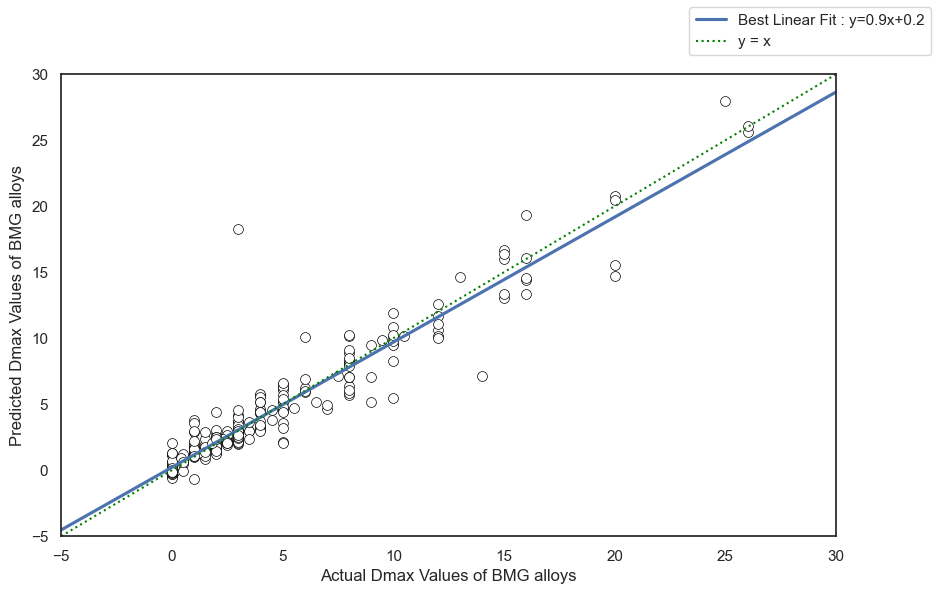

In [25]:
# Plotting the actual vs predicted values ( residual plot )
test_pred =cat_model.predict(X_test).reshape(-1,1)[:,0]

d = {'Predicted Dmax Values': list(test_pred), 'Actual Dmax Values': list(y_test.reshape(-1,1)[:,0])} #['Mean_BulkModulus']
df = pd.DataFrame(d)

sns.set_theme(style="white")
fig = plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
ax.set_xlim(-5.0, 30.0)
ax.set_ylim(-5.0, 30.0)
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Actual Dmax Values'],df['Predicted Dmax Values'])
sns.scatterplot(x = 'Actual Dmax Values',y = 'Predicted Dmax Values',data = df, edgecolor="black", color="white", linewidth=0.5, s=50)
sns.regplot(x = 'Actual Dmax Values',y = 'Predicted Dmax Values', label="Best Linear Fit : " + "y={0:.1f}x+{1:.1f}".format(slope,intercept), data = df,fit_reg=True, truncate=False, ci=False, scatter=False)
temp = np.linspace(-5, 30, 10)
plt.plot(temp, temp, linestyle=":", color="green", label="y = x")
plt.xlabel('Actual Dmax Values of BMG alloys')
plt.ylabel('Predicted Dmax Values of BMG alloys')
fig.legend()
plt.show()

In [18]:
# Calculating the mean residual error
mean_residual_error = np.mean(np.abs(y_test - test_pred))

In [21]:
print(f"Mean Residual Error of test dataset: {mean_residual_error}")

Mean Residual Error of test dataset: 0.6974082023965925
